In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
stock_data = pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv', parse_dates=['Date'])
stock_data.sort_values(by='Date', ascending=True, inplace=True)
stock_data = stock_data.reset_index()
stock_data.rename(columns={'Turnover (Lacs)': 'Turnover'}, inplace=True)
stock_data['Price'] = (stock_data['Turnover'] / stock_data['Total Trade Quantity']) * 100000
stock_data.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover,Price
0,1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,156.296192
1,1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,156.348618
2,1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,159.329095
3,1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,161.206694
4,1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,159.127498


In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

seq_length = 5
price_data = stock_data['Price'].to_frame()
sc = MinMaxScaler(feature_range = (0, 1))
price_data = sc.fit_transform(price_data)
x, y = sliding_windows(price_data, seq_length)

In [6]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMForecast, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, dropout=0.2)
        self.linear = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input):
        output, (h, c) = self.lstm(input)
        h = h.to(device)
        out = self.linear(h)
        return out

num_epochs = 1000
learning_rate = 0.0001
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
num_layers = 1
hidden_size = 256

x_train, x_test, y_train, y_test = x[:-5], x[-5:], y[:-5], y[-5:]
x_train = torch.from_numpy(x_train).type(torch.FloatTensor) 
x_test = torch.from_numpy(x_test).type(torch.FloatTensor) 
y_train = torch.from_numpy(y_train).type(torch.FloatTensor) 
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False)

model = LSTMForecast(input_size, hidden_size, num_layers, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss(reduction = 'mean')

model.train()

for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(train_loader):
        inp_data = batch[0].to(device)
        inp_data = inp_data.permute(1,0,2)
        target = batch[1].to(device)
        model = model.to(device)
        output = model(inp_data)
        optimizer.zero_grad()

        loss = criterion(output.squeeze(0), target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
    print(f'Epoch {epoch} / {num_epochs} done..')
    print(f'Training Loss {loss}')

model.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        inp_data = batch[0].to(device)
        inp_data = inp_data.permute(1,0,2)
        target = batch[1].to(device)
        output = model(inp_data)
        p = torch.from_numpy(sc.inverse_transform(output.cpu().data.numpy().squeeze(0)))
        o = torch.from_numpy(sc.inverse_transform(target.cpu().data.numpy()))
        loss = criterion(p, o)
        print(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0 / 1000 done..
Training Loss 0.255391389131546
Epoch 1 / 1000 done..
Training Loss 0.12345286458730698
Epoch 2 / 1000 done..
Training Loss 0.08682452142238617
Epoch 3 / 1000 done..
Training Loss 0.07680217921733856
Epoch 4 / 1000 done..
Training Loss 0.06690093874931335
Epoch 5 / 1000 done..
Training Loss 0.05729573220014572
Epoch 6 / 1000 done..
Training Loss 0.04735305532813072
Epoch 7 / 1000 done..
Training Loss 0.036592721939086914
Epoch 8 / 1000 done..
Training Loss 0.024913305416703224
Epoch 9 / 1000 done..
Training Loss 0.013292115181684494
Epoch 10 / 1000 done..
Training Loss 0.005001794546842575
Epoch 11 / 1000 done..
Training Loss 0.0031629616860300303
Epoch 12 / 1000 done..
Training Loss 0.0040291729383170605
Epoch 13 / 1000 done..
Training Loss 0.0030566551722586155
Epoch 14 / 1000 done..
Training Loss 0.002764800563454628
Epoch 15 / 1000 done..
Training Loss 0.0029321545735001564
Epoch 16 / 1000 done..
Training Loss 0.0029030211735516787
Epoch 17 / 1000 done..
Train

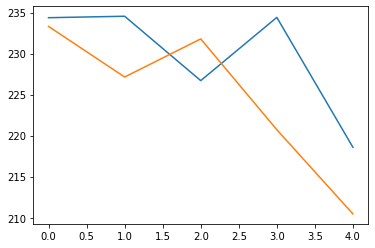

In [5]:
plt.plot(sc.inverse_transform(model(x_test.to(device)).cpu().data.numpy().squeeze(0)))
plt.plot(sc.inverse_transform(y_test.data.numpy()))
plt.show()